# Banana Collector!

## Modules

In [1]:
!pip -q install ./python
!pip install requests
from unityagents import UnityEnvironment
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributed import barrier
from torch.optim.lr_scheduler import ReduceLROnPlateau
from collections import namedtuple, deque
#from workspace_utils import active_session

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.


  Using cached requests-2.27.1-py2.py3-none-any.whl (63 kB)
  Using cached idna-3.3-py3-none-any.whl (61 kB)
  Using cached charset_normalizer-2.0.12-py3-none-any.whl (39 kB)


## Variables

In [2]:
num_episodes = 1000        # Number of episodes
buffer_size = int(10e6)    # Size of "memory" for previous steps
batch_size = 32            # Size of random steps to pass to network
gamma = 0.99               # Discount factor
tau = 10e-4                # Scale factor to update target policy network
lr =  0.0005               # Learning rate for current policy network
update = 4                 # Number of runs before learning
epsilon_start = 1.0        # Starting value for epsilon
epsilon_end = 0.05         # Ending value for epsilon
epsilon_decay = 0.992      # Epsilon decay rate

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")     # Get device (CPU vs GPU)

## Create environment and get the default brain

In [3]:
# Create environment

env = UnityEnvironment(file_name="Banana_Windows_x86_64\\Banana.exe")

# Get brain names

brain_name = env.brain_names[0]

# Get default brain

brain = env.brains[brain_name]

# Get size of action space

action_size = brain.vector_action_space_size

# Get information on the environment

env_info = env.reset(train_mode=True)[brain_name]

# Get first state

state = env_info.vector_observations[0]

# Get size of state space

state_size = len(state)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


## Policy Network

In [4]:
class Q_FCN(nn.Module):

    def __init__(self, state_size, action_size):
        super(Q_FCN, self).__init__()

        self.seed = torch.manual_seed(0)
        self.fcn1 = nn.Linear(state_size, state_size*16)      # Input 37, Output 592 
        self.fcn2 = nn.Linear(state_size*16, state_size*8)   # Input 592, Output 296
        self.fcn3 = nn.Linear(state_size*8, action_size)     # Input 296, Output 4
        
        self.relu = nn.ReLU6()

    def forward(self, state):
        
        x = self.relu(self.fcn1(state))
        x = self.relu(self.fcn2(x))
        x = self.fcn3(x)
        
        return x


## Create Agent

In [6]:
# Create an Agent class - instantiates, runs, and tracks runs through the environment
class Agent():
    def __init__(self, state_size, action_size, update, batch_size, buffer_size):
        super(Agent,self).__init__()
        
        # Make all input variables local
        
        self.state_size = state_size
        self.action_size = action_size
        self.update_after = update
        self.batch_size = batch_size
        
        # Create fully connected linear networks for current and target policies
        
        self.q_current = Q_FCN(state_size, action_size).to(device)
        self.q_target = Q_FCN(state_size, action_size).to(device)
        
        # Optimizer for current policy network
        
        self.optimizer = optim.Adam(self.q_current.parameters(), lr=lr)
        #self.scheduler = ReduceLROnPlateau(self.optimizer, patience = 100, verbose = True)
        
        # Create container to hold memory of previous state, action, reward, and next state (SARS)
        
        self.Mem = Memories(action_size, buffer_size, batch_size)
        
        # Counter to determine when to update
        
        self.t_step = 0
        
    def act(self, state, epsilon = 0):
        
        # Create torch tensor from numpy state array
        
        state = torch.from_numpy(state).float()
        
        # Expand state tensor to 2D and move to CPU or GPU
        
        state = state.unsqueeze(0).to(device)
        
        # Set current policy network to evaluation mode
        
        self.q_current.eval()
        
        # Turn off gradients
        
        with torch.no_grad():
            
            #Get action values by running the state tensor through the current policy network
            
            action_values = self.q_current(state)
            
        # Set current policy network back to training mode
        
        self.q_current.train()
        
        # Get action
        
        # Compare a randomly generated number with epsilon
        if random.random() > epsilon:
            
            # If the random number is higher than epsilon, choose the maximum value in action_values
            
            action = np.argmax(action_values.cpu().data.numpy())
            
        else:
        
            # If the random number is lower than epsilon, choose a random action within the action space
            
            action = random.choice(np.arange(self.action_size))
        
        # Return the action
        return action
    
    
    def step(self, state, action, reward, next_state, done, gamma, tau):
        
        # Save current SARS to memory
        
        self.Mem.add(state, action, reward, next_state, done)
        
        # Increment the update tracker
        
        self.t_step += 1
        
        # Check if learning for current and target policy is necessary
        
        if self.t_step % self.update_after == 0:
            
            #If there are enough saved SARS to run a learning step
            
            if self.Mem.__len__() > self.batch_size:
                
                #Sample the saved memories to create a batch of experiences
                
                experiences = self.Mem.sample()
                
                #Update current and target policy networks using past experiences
                
                self.learn(experiences, gamma, tau)

                
    def learn(self, experiences, gamma, tau):
        
        # Unpack the experiences array
        
        states, actions, rewards, next_states, dones = experiences
        
        # Move all variables to either CPU or GPU
        
        next_states.to(device)
        states.to(device)
        rewards.to(device)
        actions.to(device)
        dones.to(device)
        
        # DOUBLE DQN
        
        # Turn off training of target network
        
        self.q_target.eval()
        #self.q_current.eval()
        
        # Get prediction of optimum action based on next states
        
        max_act_local = self.q_current(next_states).detach().max(1)[1].unsqueeze(1).long()
        
        # Evaluate the output of current policy network using target policy network
        
        next_q = self.q_target(next_states).gather(1,max_act_local).detach()
        
        # Calculate gamma-weighted targets
        
        nxt = (rewards + (gamma * next_q * (1-dones)))#.cpu().detach()
        
        # Turn on training for current and target policy networks
        
        self.q_target.train()
        #self.q_current.train()
        
        # Get prediction of actions for current batch of states
        
        curr_q = self.q_current(states).gather(1,actions)
        
        # Calculate loss using current prediction of actions and double-DQN prediction
        
        loss = F.mse_loss(curr_q, nxt)
        
        # Zero optimizer gradients
        
        self.optimizer.zero_grad()
        
        # Propagate loss backwards through current policy network
        
        loss.backward()
        
        # Step ADAM optimizer to update network parameters
        
        self.optimizer.step()
        
        # Step scheduler to update learning rate if necessary
        
        #self.scheduler.step(loss)
        
        # Update target policy network parameters using current policy network parameters and weight tau
        
        # For every parameter in the target and current policy networks,
        
        for target_param, current_param in zip(self.q_target.parameters(), self.q_current.parameters()):
            
            # Update the target policy network parameters based on a 
            # weighted combination of both network parameter values
            
            target_param.data.copy_(tau*current_param.data + (1.0-tau)*target_param.data)
        

## Class for creating, adding, and sampling memories

In [7]:
class Memories:
    
    def __init__(self, action_size, buffer_size, batch_size):
        super(Memories, self).__init__()
        
        # Set inputs as local variables
        
        self.action_size = action_size
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        
        # Create memory to hold experiences
        
        self.memory = deque(maxlen=buffer_size)
        
        # Create namedtuple format for experiences (SARS)
        
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        
        # Set a static seed for consistency between runs
        
        self.seed = random.seed(0)
        
    def add(self, state, action, reward, next_state, done):
        
        # Create namedtuple for current data
        current = self.experience(state, action, reward, next_state, done)
        
        # Add namedtuple to deque
        self.memory.append(current)
        
    def sample(self):
        
        # Extract a batch of experiences from memory
        experiences = random.sample(self.memory, k = self.batch_size)
    
        # Split experiences into states, actions, rewards, next_states, and dones
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        
        return (states, actions, rewards, next_states, dones)
    
    def __len__(self):
        
        # Get current memory size
        
        mem_size = len(self.memory)
        
        return mem_size

## Run Agent through Environment and Train to Optimize Policy

In [8]:
agent = Agent(state_size, action_size, update, batch_size, buffer_size)

scores = []                                                               # List to track scores
avg_scores = []                                                           # List to store average scores
prev_scores = deque(maxlen = 100)                                         # Deque to hold previous scores
epsilon = epsilon_start                                                   # Set epsilon


#with active_session():

for curr_ep in range(1, num_episodes + 1):
    env_info = env.reset(train_mode=True)[brain_name]                     # Reset environment  
    state = env_info.vector_observations[0]                               # Get current state
    score = 0                                                             # Initialize score

    while True:                   
        action = agent.act(state, epsilon)                                # select an action
        env_info = env.step(int(action))[brain_name]                           # send the action to the environment
        next_state = env_info.vector_observations[0]                      # get the next state
        reward = env_info.rewards[0]                                      # get the reward
        done = env_info.local_done[0]                                     # see if episode has finished
        agent.step(state, action, reward, next_state, done, gamma, tau)   # Pass the SARS to the agent
        state = next_state                                                # roll over the state to next time step
        score += reward                                                   # update the score
        if done:                                                          # exit loop if episode finished
            break

    prev_scores.append(score)                                             # save most recent score in deque for rolling average
    scores.append(score)                                                  # save most recent score
    epsilon = max(epsilon_end, epsilon_decay*epsilon)                     # decrease epsilon
    avg_score = np.mean(prev_scores)                                      # get rolling average score
    avg_scores.append(avg_score)

    if avg_score < 13:
        print("Epoch: {}  Average Score: {}".format(curr_ep, avg_score), end='\r')
    else:
        print("\nGood monkey! Bananas collected in {} epochs!".format(curr_ep))
        torch.save(agent.q_current.state_dict(), 'bananas_solved.pth')
        break

Epoch: 562  Average Score: 12.97464646464645585
Good monkey! Bananas collected in 563 epochs!


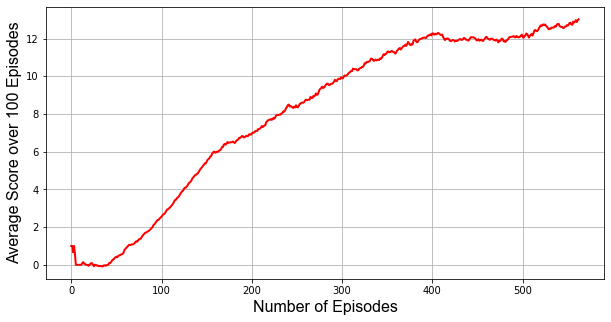

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10,5), facecolor='white')
plt.grid(True)
plt.plot(avg_scores, linewidth=2, color='red')
plt.xlabel("Number of Episodes", loc='center', fontsize=16, fontfamily='Arial')
plt.ylabel("Average Score over 100 Episodes", loc='center', fontsize=16, fontfamily='Arial')
plt.show()

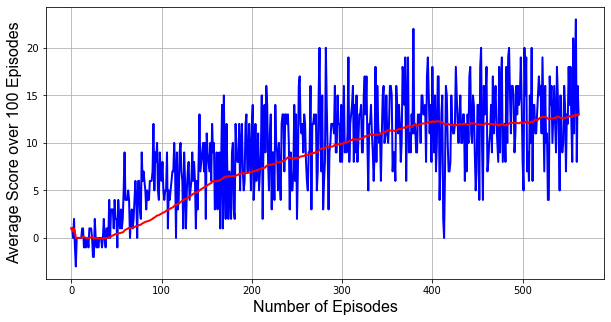

In [20]:
plt.figure(figsize=(10,5), facecolor='white')
plt.grid(True)
plt.plot(scores, linewidth=2, color='blue')
plt.plot(avg_scores, linewidth=2, color='red')
plt.xlabel("Number of Episodes", loc='center', fontsize=16, fontfamily='Arial')
plt.ylabel("Average Score over 100 Episodes", loc='center', fontsize=16, fontfamily='Arial')
plt.show()